In [ ]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import inf
import torch


In [ ]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive') 

In [ ]:
import os

def get_words_in_file(filename):
    """ Returns a list of all words in the file at filename. """
    with open(filename, 'r', encoding = "ISO-8859-1") as f:
        # read() reads in a string from a file pointer, and split() splits a
        # string into words based on whitespace
        words = f.read().split()
    return words

def get_files_in_folder(folder):
    """ Returns a list of files in folder (including the path to the file) """
    filenames = os.listdir(folder)
    # os.path.join combines paths while dealing with /s and \s appropriately
    full_filenames = [os.path.join(folder, filename) for filename in filenames]
    return full_filenames

def get_counts(file_list):
    """ 
    Returns a dict whose keys are words and whose values are the number of 
    files in file_list the key occurred in. 
    """
    counts = Counter()
    for f in file_list:
        words = get_words_in_file(f)
        for w in set(words):
            counts[w] += 1
    return counts

def get_word_freq(file_list):
    """ 
    Returns a dict whose keys are words and whose values are word freq
    """
    counts = Counter()
    for f in file_list:
        words = get_words_in_file(f)
        for w in words:
            counts[w] += 1
    return counts

class Counter(dict):
    """
    Like a dict, but returns 0 if the key isn't found.
    """
    def __missing__(self, key):
        return 0



In [ ]:
def learn_distributions(file_lists_by_category):
    """
    Estimate the parameters p_d, and q_d from the training set
    
    Input
    -----
    file_lists_by_category:  A two-element list. 
                             The first element is a list of spam files, 
                             and the second element is a list of ham files.

    Output
    ------
    probabilities_by_category: A two-element tuple. 
                              The first element is a dict whose keys are words, and whose values are the smoothed estimates of p_d;
                              the second element is a dict whose keys are words, and whose values are the smoothed estimates of q_d 
    """
    ### TODO: Write your code here

    spam_file_list = file_lists_by_category[0]
    ham_file_list = file_lists_by_category[1]
    

    spam_dic = get_word_freq(spam_file_list)
    ham_dic = get_word_freq(ham_file_list)
    total_dic = get_word_freq(spam_file_list + ham_file_list)

    tot_words_spam = sum(spam_dic.values())
    tot_words_ham = sum(ham_dic.values())
    tot_distinct_words = len(total_dic)
    
    first_dic = {}
    second_dic = {}
    for wd in total_dic:
      p_d = (spam_dic[wd]+1)/(tot_words_spam + tot_distinct_words)
      q_d = (ham_dic[wd]+1)/(tot_words_ham + tot_distinct_words)
      first_dic[wd] = p_d
      second_dic[wd] = q_d
        
    probabilities_by_category = (first_dic, second_dic)
    
    return probabilities_by_category


In [ ]:
def classify_new_email(filename,probabilities_by_category,prior_by_category,p_tradeoff):
    """
    Use Naive Bayes classification to classify the email in the given file.

    Inputs
    ------
    filename: name of the file to be classified
    
    probabilities_by_category: output of function learn_distributions
    
    prior_by_category: A two-element list as [\pi, 1-\pi], where \pi is the parameter in the prior class distribution

    Output
    ------
    classify_result: A two-element tuple. 
                    The first element is a string whose value is either 'spam' or 'ham' depending on the classification result, 
                    and the second element is a two-element list as [log p(y=1|x), log p(y=0|x)], representing the log posterior probabilities
    """
    ### TODO: Write your code here

    ###word_list = get_words_in_file(filename)
    ###dic_word_freq = Counter()
    ###for wd in word_list:
    ###        dic_word_freq[wd] += 1

    filename_list = (filename, 1)
    dic_word_freq = get_word_freq(filename_list[0:1])

    spam_prior = prior_by_category[0]
    ham_prior = prior_by_category[1]

    log_spam_prior = np.log(spam_prior)
    log_ham_prior = np.log(ham_prior)

    log_spam_likelihood = 0
    log_ham_likelihood = 0

    for wd in dic_word_freq:
      if wd in probabilities_by_category[0] and wd in probabilities_by_category[1]:
        log_spam_likelihood = log_spam_likelihood + np.log(probabilities_by_category[0][wd]) * dic_word_freq[wd] 
        log_ham_likelihood = log_ham_likelihood + np.log(probabilities_by_category[1][wd]) * dic_word_freq[wd]
        
    log_spam_posterior = log_spam_prior + log_spam_likelihood 
    log_ham_posterior = log_ham_prior + log_ham_likelihood 

    if log_spam_posterior >= log_ham_posterior + np.log(p_tradeoff):
      result_str = 'spam'
    else:
      result_str = 'ham'

    classify_result = (result_str, [log_spam_posterior, log_ham_posterior])

    return classify_result


In [ ]:
if __name__ == '__main__':
    
    # folder for training and testing 
    spam_folder = '/content/gdrive/My Drive/ECE368/data/spam/'
    ham_folder = '/content/gdrive/My Drive/ECE368/data/ham/'
    test_folder = '/content/gdrive/My Drive/ECE368/data/testing/'

    # generate the file lists for training
    file_lists = []
    for folder in (spam_folder, ham_folder):
        file_lists.append(get_files_in_folder(folder))
        
    # Learn the distributions    
    probabilities_by_category = learn_distributions(file_lists)
    
    # prior class distribution
    priors_by_category = [0.5, 0.5]
    
    # Store the classification results
    performance_measures = np.zeros([2,2])
    # explanation of performance_measures:
    # columns and rows are indexed by 0 = 'spam' and 1 = 'ham'
    # rows correspond to true label, columns correspond to guessed label
    # to be more clear, performance_measures = [[p1 p2]
    #                                           [p3 p4]]
    # p1 = Number of emails whose true label is 'spam' and classified as 'spam' 
    # p2 = Number of emails whose true label is 'spam' and classified as 'ham' 
    # p3 = Number of emails whose true label is 'ham' and classified as 'spam' 
    # p4 = Number of emails whose true label is 'ham' and classified as 'ham' 


    p_tradeoff = 1
    # Classify emails from testing set and measure the performance
    for filename in (get_files_in_folder(test_folder)):
        # Classify
        label,log_posterior = classify_new_email(filename,
                                                 probabilities_by_category,
                                                 priors_by_category,p_tradeoff)
        
        # Measure performance (the filename indicates the true label)
        base = os.path.basename(filename)
        true_index = ('ham' in base) 
        guessed_index = (label == 'ham')
        performance_measures[int(true_index), int(guessed_index)] += 1

    template="You correctly classified %d out of %d spam emails, and %d out of %d ham emails."
    # Correct counts are on the diagonal
    correct = np.diag(performance_measures)
    # totals are obtained by summing across guessed labels
    totals = np.sum(performance_measures, 1)
    print(template % (correct[0],totals[0],correct[1],totals[1]))
    
    

You correctly classified 47 out of 49 spam emails, and 47 out of 51 ham emails.


In [ ]:
def make_prediction(priors_by_category, test_folder, probabilities_by_category):
    # Store the classification results
    performance_measures = np.zeros([2,2])
    # explanation of performance_measures:
    # columns and rows are indexed by 0 = 'spam' and 1 = 'ham'
    # rows correspond to true label, columns correspond to guessed label
    # to be more clear, performance_measures = [[p1 p2]
    #                                           [p3 p4]]
    # p1 = Number of emails whose true label is 'spam' and classified as 'spam' 
    # p2 = Number of emails whose true label is 'spam' and classified as 'ham' 
    # p3 = Number of emails whose true label is 'ham' and classified as 'spam' 
    # p4 = Number of emails whose true label is 'ham' and classified as 'ham' 

    # Classify emails from testing set and measure the performance
    for filename in (get_files_in_folder(test_folder)):
      # Classify
      #print(filename)
      label,log_posterior = classify_new_email(filename,
                                               probabilities_by_category,
                                               priors_by_category, p_tradeoff)
      
      # Measure performance (the filename indicates the true label)
      base = os.path.basename(filename)
      true_index = ('ham' in base) 
      guessed_index = (label == 'ham')
      performance_measures[int(true_index), int(guessed_index)] += 1

    template="You correctly classified %d out of %d spam emails, and %d out of %d ham emails."
    # Correct counts are on the diagonal
    correct = np.diag(performance_measures)
    # totals are obtained by summing across guessed labels
    totals = np.sum(performance_measures, 1)
    print(template % (correct[0],totals[0],correct[1],totals[1]))
    error1 = totals[0] - correct[0]
    error2 = totals[1] - correct[1]
    return error1, error2


You correctly classified 49 out of 49 spam emails, and 7 out of 51 ham emails.
You correctly classified 49 out of 49 spam emails, and 14 out of 51 ham emails.
You correctly classified 49 out of 49 spam emails, and 17 out of 51 ham emails.
You correctly classified 49 out of 49 spam emails, and 34 out of 51 ham emails.
You correctly classified 47 out of 49 spam emails, and 44 out of 51 ham emails.
You correctly classified 47 out of 49 spam emails, and 47 out of 51 ham emails.
You correctly classified 46 out of 49 spam emails, and 48 out of 51 ham emails.
You correctly classified 35 out of 49 spam emails, and 50 out of 51 ham emails.
You correctly classified 19 out of 49 spam emails, and 50 out of 51 ham emails.
You correctly classified 2 out of 49 spam emails, and 51 out of 51 ham emails.
[0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 14.0, 30.0, 47.0] [44.0, 37.0, 34.0, 17.0, 7.0, 4.0, 3.0, 1.0, 1.0, 0.0]


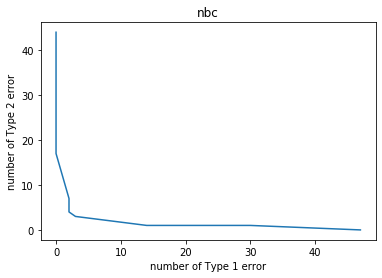

In [ ]:
error1 = []
error2 = []

error1_1, error2_1 = make_prediction([1-1e-120, 1e-120], test_folder, probabilities_by_category)
error1_2, error2_2 = make_prediction([1-1e-50, 1e-50], test_folder, probabilities_by_category)
error1_3, error2_3 = make_prediction([1-1e-30, 1e-30], test_folder, probabilities_by_category)
error1_4, error2_4 = make_prediction([1-1e-10, 1e-10], test_folder, probabilities_by_category)
error1_5, error2_5 = make_prediction([1-1e-1, 1e-1], test_folder, probabilities_by_category)
error1_6, error2_6 = make_prediction([0.5, 0.5], test_folder, probabilities_by_category)
error1_7, error2_7 = make_prediction([0.3, 0.7], test_folder, probabilities_by_category)
error1_8, error2_8 = make_prediction([1e-10, 1-1e-10], test_folder, probabilities_by_category)
error1_9, error2_9 = make_prediction([1e-20, 1-1e-20], test_folder, probabilities_by_category)
error1_10, error2_10 = make_prediction([1e-120, 1-1e-120], test_folder, probabilities_by_category)

error1 = [error1_1, error1_2, error1_3, error1_4, error1_5, error1_6, error1_7, error1_8, error1_9, error1_10]
error2 = [error2_1, error2_2, error2_3, error2_4, error2_5, error2_6, error2_7, error2_8, error2_9, error2_10]
print(error1, error2)
plt.plot(error1, error2)
plt.title("nbc")
plt.xlabel("number of Type 1 error")
plt.ylabel("number of Type 2 error")